In [2]:
import sys 
sys.path.append("../models/")
from functions import plot_style
from import_functions import get_averted_deaths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
colors = plot_style("../fonts/Encode_Sans_Condensed/")

countries = np.array(['Indonesia', 'Bolivia', 'Morocco', 'Bangladesh', 'Sri-Lanka', 'Kenya', 'Mozambique',
                      "Afghanistan", "Cote-dIvoire", "Pakistan", "El-Salvador", "Kyrgyzstan",
                      "Philippines", "Uganda", "Egypt", "Rwanda", "Zambia", "Angola", "Ghana", "Honduras"])

income = {'Indonesia': "LMI", 
          'Bolivia': "LMI", 
          'Morocco': "LMI", 
          'Bangladesh': "LMI", 
          'Sri-Lanka': "LMI", 
          'Kenya': "LMI", 
          'Mozambique': "LI",
          "Afghanistan": "LI", 
          "Cote-dIvoire": "LMI", 
          "Pakistan": "LMI", 
          "El-Salvador": "LMI", 
          "Kyrgyzstan": "LMI",
          "Philippines": "LMI", 
          "Uganda": "LI", 
          "Egypt": "LMI",
          "Rwanda": "LI", 
          "Zambia": "LI", 
          "Angola": 'LMI', 
          "Ghana": "LMI", 
          "Honduras": "LMI"}

end_date = datetime(2021, 10, 1)
start_date = datetime(2020, 12, 14)

who_regions = {'Africa': np.array(["Cote-dIvoire", 'Uganda', 'Ghana', 'Kenya', 'Rwanda', 'Angola', 'Zambia', 'Mozambique']), 
              'Americas': np.array(["El-Salvador","Honduras",'Bolivia']), 
              'Eastern Mediterranean': np.array(['Morocco', 'Egypt', 'Afghanistan', 'Pakistan']), 
              'Europe': np.array(["Kyrgyzstan"]), 
              'South-East Asia': np.array(["Philippines"]), 
              'Western Pacific': np.array(["Bangladesh", 'Sri-Lanka', 'Indonesia'])}

label_match = {"Cote-dIvoire": "Côte d'Ivoire",
               "El-Salvador": "El Salvador",
               "Sri-Lanka": "Sri Lanka"}
for c in countries:
    if c not in label_match.keys():
        label_match[c] = c

In [3]:
def import_projections(country, scenario, IQR, baseline='data-driven', path="./projections_october/"):

    # get averted deaths in perc
    avertedDeaths_perc = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=True, path=path)
    avertedDeaths_perc_med = np.median(avertedDeaths_perc)
    if IQR:

        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.25)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.75)
    else:
        avertedDeaths_perc_q1 = np.quantile(avertedDeaths_perc, q=0.05)
        avertedDeaths_perc_q2 = np.quantile(avertedDeaths_perc, q=0.95)

    # get averted deaths raw (without underreporting multiplier)
    avertedDeaths = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=False)
    avertedDeaths_med = np.median(avertedDeaths)

    # get averted deaths raw (with underreporting multiplier)
    avertedDeaths_scaled = get_averted_deaths(country, scenario, scaled=True, baseline=baseline, perc=False)
    avertedDeaths_scaled_med = np.median(avertedDeaths_scaled)

    return avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2, avertedDeaths_med, avertedDeaths_scaled_med
    

def plot_bar(ax, pos, med, q1, q2, color):
    ax.scatter([pos], [med], color=color, s=80, edgecolor='white', linewidth=0.7, zorder=1, marker="o")
    ax.plot([pos, pos], [q1, q2], color=color, solid_capstyle='round', linewidth=8, alpha=0.5, zorder=-1)


def barplot(ax, scenario, start_i, countries_grp, IQR, baseline='data-driven', path="./projections_october/"):
    # get projections
    avertedDeaths_perc_med, avertedDeaths_perc_q1, avertedDeaths_perc_q2 = np.zeros(len(countries_grp)), np.zeros(len(countries_grp)), np.zeros(len(countries_grp))
    avertedDeaths_med, avertedDeaths_scaled_med = np.zeros(len(countries_grp)), np.zeros(len(countries_grp)) 

    colors_income = []
    for i in range(len(countries_grp)):
        country = countries_grp[i]
        perc_med, perc_q1, perc_q2, med, scaled_med = import_projections(country, scenario, IQR, baseline=baseline, path=path)
        avertedDeaths_perc_med[i] = perc_med
        avertedDeaths_perc_q1[i] = perc_q1
        avertedDeaths_perc_q2[i] = perc_q2
        avertedDeaths_med[i] = med
        avertedDeaths_scaled_med[i] = scaled_med

        if income[country] == "LMI":
            colors_income.append('#DD6E42')
        elif income[country] == "LI":
            colors_income.append('#FFC857')

    # plot  
    idx = np.argsort(avertedDeaths_perc_med)#[::-1]

    for i in range(len(idx)):
        plot_bar(ax, start_i + i, avertedDeaths_perc_med[idx[i]], avertedDeaths_perc_q1[idx[i]], avertedDeaths_perc_q2[idx[i]], colors_income[idx[i]])
        
        if avertedDeaths_med[idx[i]] < 10000:
            ax.annotate(xy=(start_i + i, avertedDeaths_perc_q2[idx[i]]+2.7), text=str(np.round(avertedDeaths_med[idx[i]] / 1000, 1)) + "K", size=7, color="grey", ha="center")
        else:
            ax.annotate(xy=(start_i + i, avertedDeaths_perc_q2[idx[i]]+2.7), text=str(int(avertedDeaths_med[idx[i]] / 1000)) + "K", size=7, color="grey", ha="center")

    ax.set_ylabel("Averted Deaths (%)",  fontsize=8)    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.grid(True, color='grey', linewidth=0.1, zorder=-1, linestyle="--")
    ax.set_axisbelow(True)
    ax.tick_params(axis="y", labelsize=8)

    return countries_grp[idx], avertedDeaths_perc_med

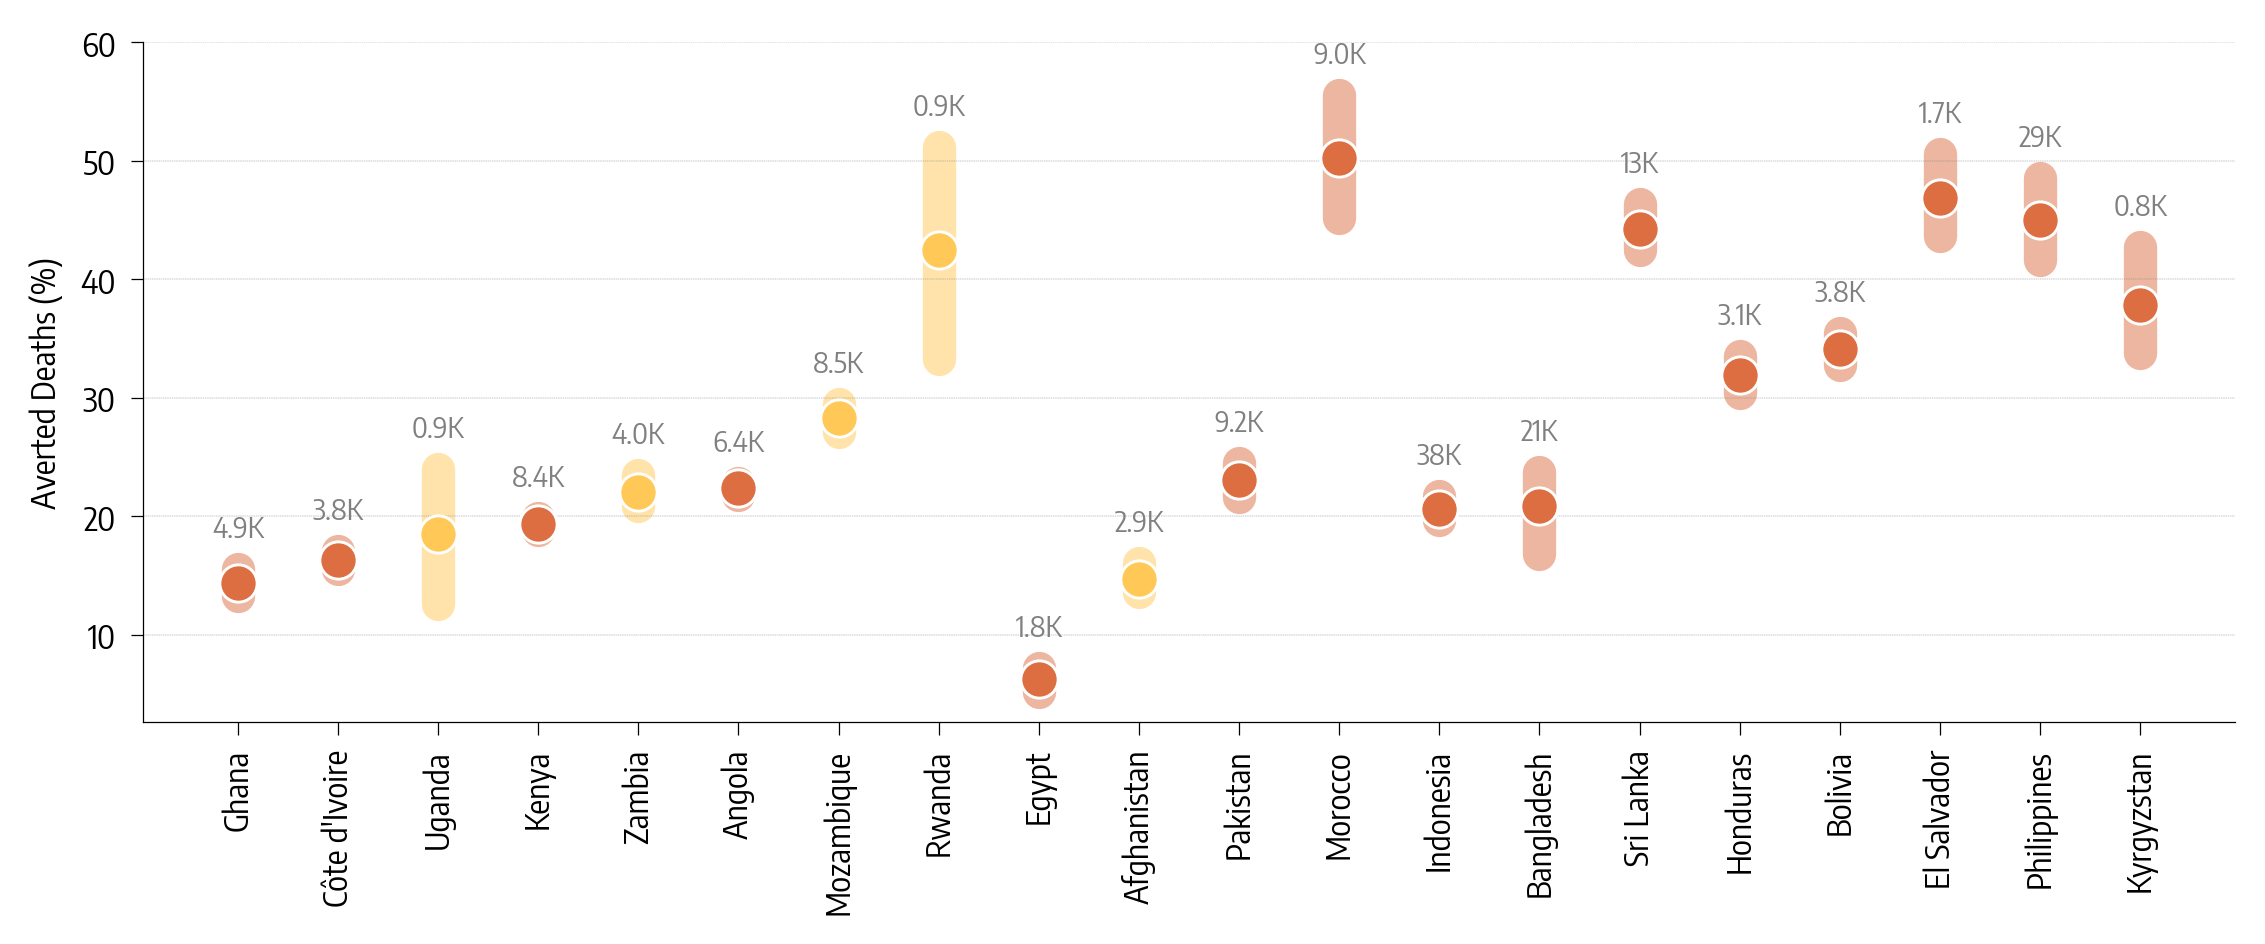

In [4]:
countries_ticks, avertedDeaths_perc_med = [], []
fig, ax = plt.subplots(dpi=300, figsize=(9,3))

cc, av = barplot(ax=ax, scenario="us_start", start_i=0, 
                 countries_grp=who_regions['Africa'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

cc, av = barplot(ax=ax, scenario="us_start", start_i=len(who_regions['Africa']), 
                 countries_grp=who_regions['Eastern Mediterranean'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_start", start_i=len(who_regions['Africa']) + len(who_regions['Eastern Mediterranean']), 
                 countries_grp=who_regions['Western Pacific'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

cc, av = barplot(ax=ax, scenario="us_start", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']), 
                 countries_grp=who_regions['Americas'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_start", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']) + len(who_regions['Americas']), 
                 countries_grp=who_regions['South-East Asia'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)


cc, av = barplot(ax=ax, scenario="us_start", start_i=len(who_regions['Africa']) + len(who_regions['Western Pacific']) + len(who_regions['Eastern Mediterranean']) + len(who_regions['Americas']) + len(who_regions['South-East Asia']), 
                 countries_grp=who_regions['Europe'], IQR=True, baseline='data-driven', 
                 path="./projections_october/")
countries_ticks.extend(cc)
avertedDeaths_perc_med.extend(av)

ax.set_xticks(range(20))
ax.set_xticklabels([label_match[c] for c in countries_ticks], rotation=90, size=8);

ax.set_ylim(ymax=60)

plt.savefig('./img/averted_deaths_us_start_IQR_grp.pdf')

In [5]:
print('Averted Deaths %')
print(f'Min: {np.min(avertedDeaths_perc_med)}')
print(f'Max: {np.max(avertedDeaths_perc_med)}')
print(f'Average: {np.mean(avertedDeaths_perc_med)}')
print(f'Median: {np.median(avertedDeaths_perc_med)}')

Averted Deaths %
Min: 6.248510659022795
Max: 50.246198177646136
Average: 27.98017640968095
Median: 22.729931729592252


In [6]:
for country in ["Kenya", "Afghanistan", 'Honduras', 'Cote-dIvoire', 'Kyrgyzstan', 'Zambia',
                'Ghana', 'Sri-Lanka', 'El-Salvador', 'Indonesia', 'Morocco', 'Mozambique',
                'Angola','Bolivia', 'Uganda', 'Philippines', 'Bangladesh', 'Rwanda',
                'Egypt', 'Pakistan']:
    print(country)
    avertedDeaths = get_averted_deaths(country, 'us_start', scaled=False, baseline='data-driven', perc=True, path='./projections_october/')
    med, q1, q2 = np.median(avertedDeaths), np.quantile(avertedDeaths, q=0.25), np.quantile(avertedDeaths, q=0.75)
    print('\t{:.1f} [{:.1f}, {:.1f}]'.format(med, q1, q2))
    print("\n")



Kenya
	19.4 [18.9, 19.8]


Afghanistan
	14.7 [13.6, 16.1]


Honduras
	31.9 [30.4, 33.6]


Cote-dIvoire
	16.3 [15.5, 17.1]


Kyrgyzstan
	37.8 [33.7, 42.8]


Zambia
	22.1 [20.9, 23.5]


Ghana
	14.4 [13.3, 15.6]


Sri-Lanka
	44.3 [42.4, 46.4]


El-Salvador
	46.9 [43.6, 50.5]


Indonesia
	20.6 [19.7, 21.7]


Morocco
	50.2 [45.2, 55.6]


Mozambique
	28.3 [27.1, 29.5]


Angola
	22.4 [21.8, 22.8]


Bolivia
	34.1 [32.8, 35.5]


Uganda
	18.5 [12.6, 24.0]


Philippines
	45.0 [41.6, 48.6]


Bangladesh
	20.9 [16.8, 23.7]


Rwanda
	42.4 [33.3, 51.1]


Egypt
	6.2 [5.2, 7.2]


Pakistan
	23.1 [21.6, 24.5]




In [7]:
for country in ["Kenya", "Afghanistan", 'Honduras', 'Cote-dIvoire','Kyrgyzstan', 'Zambia',
                'Ghana', 'Sri-Lanka', 'El-Salvador', 'Indonesia', 'Morocco', 'Mozambique',
                'Angola','Bolivia', 'Uganda', 'Philippines', 'Bangladesh', 'Rwanda',
                'Egypt', 'Pakistan']:
    print(country)
    avertedDeaths = get_averted_deaths(country, 'us_start', scaled=False, baseline='data-driven', perc=False, path='./projections_october/')
    med, q1, q2 = np.median(avertedDeaths/1000), np.quantile(avertedDeaths/1000, q=0.25), np.quantile(avertedDeaths/1000, q=0.75)
    print('\t{:.1f}K [{:.1f}K, {:.1f}K]'.format(med, q1, q2))
    print("\n")



Kenya
	8.4K [6.4K, 11.3K]


Afghanistan
	2.9K [2.3K, 3.9K]


Honduras
	3.1K [2.5K, 3.7K]


Cote-dIvoire
	3.8K [3.1K, 4.4K]


Kyrgyzstan
	0.8K [0.6K, 1.2K]


Zambia
	4.0K [3.1K, 4.8K]


Ghana
	4.9K [3.8K, 6.3K]


Sri-Lanka
	13.5K [10.7K, 17.7K]


El-Salvador
	1.7K [1.4K, 2.2K]


Indonesia
	38.0K [31.5K, 45.7K]


Morocco
	9.0K [7.1K, 11.6K]


Mozambique
	8.5K [6.4K, 11.0K]


Angola
	6.4K [5.0K, 8.6K]


Bolivia
	3.8K [3.5K, 4.0K]


Uganda
	0.9K [0.5K, 1.2K]


Philippines
	29.4K [24.9K, 34.1K]


Bangladesh
	22.0K [15.3K, 31.3K]


Rwanda
	0.9K [0.5K, 1.4K]


Egypt
	1.8K [1.5K, 2.2K]


Pakistan
	9.2K [6.8K, 12.1K]


